This Notebook, is designed to perform and evaluate stain normalization on histopathology images. It's an important preprocessing step for machine learning models to reduce color and intensity variations.

**Purpose**
The primary purpose of this notebook is to demonstrate and compare three advanced stain normalization techniques:

* **Reinhard's method**: A technique


that normalizes images by matching the mean and standard deviation of color channels between the source and a target image in the lαβ color space.

* **Macenko's method:** This method uses a singular value decomposition (SVD) approach to separate the Hematoxylin and Eosin (H&E) stains in optical density (OD) space, then scales the source stain concentrations to match the reference.

* **Vahadane's method:** A non-negative matrix factorization (NMF)-based approach that models stain concentration and color matrices to normalize the images.

The code evaluates the effectiveness of each method using quantitative metrics like Structural Similarity Index Measure (*SSIM*) and Peak Signal-to-Noise Ratio (*PSNR*), which are common for assessing image quality and structural preservation.

In [ ]:
#Mounting drive
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install librairies
!pip install staintools
!pip install spams
!pip install torchstain

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14048 sha256=4823cad19bf1c19d7d93647c01893fb4fd91a7f653301c00e0d4a054fba05b5c
  Stored in directory: /root/.cache/pip/wheels/83/01/30/d5b79f92442193b7e3229cb20fb8458e765594cc2251f87ae6
Successfully built staintools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp310-cp310-linux_x86_64.whl size=3932004 sha256=84ad11d2b15b9b98a4c92c5d9cbbba61e82ade5ba58c03d288c961e1a81ab423
  Stored in directory: /root/.cache/pip/wheels/67/9d/1f/60a6c60785b07ad4f087297f04b723e665a97afcd5112ffb06
Successfully built spams


In [ ]:
#import librairies
import sys
import re
import gc
import time
import os
import zipfile
import cv2
import staintools
import pandas as pd

from glob import glob
from tqdm.notebook import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image
import matplotlib.pyplot as plt
import tifffile as tiff

from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
%matplotlib inline

In [ ]:
#Loding images: defines the paths and loads the sources and target images into the notebook for processing
source = cv2.imread('/content/drive/MyDrive/normal stain/Copie de 4019d_5.jpg', cv2.COLOR_BGR2RGB )

target = tiff.imread('/content/drive/MyDrive/normal stain/madurella-mycetomatis.tif')


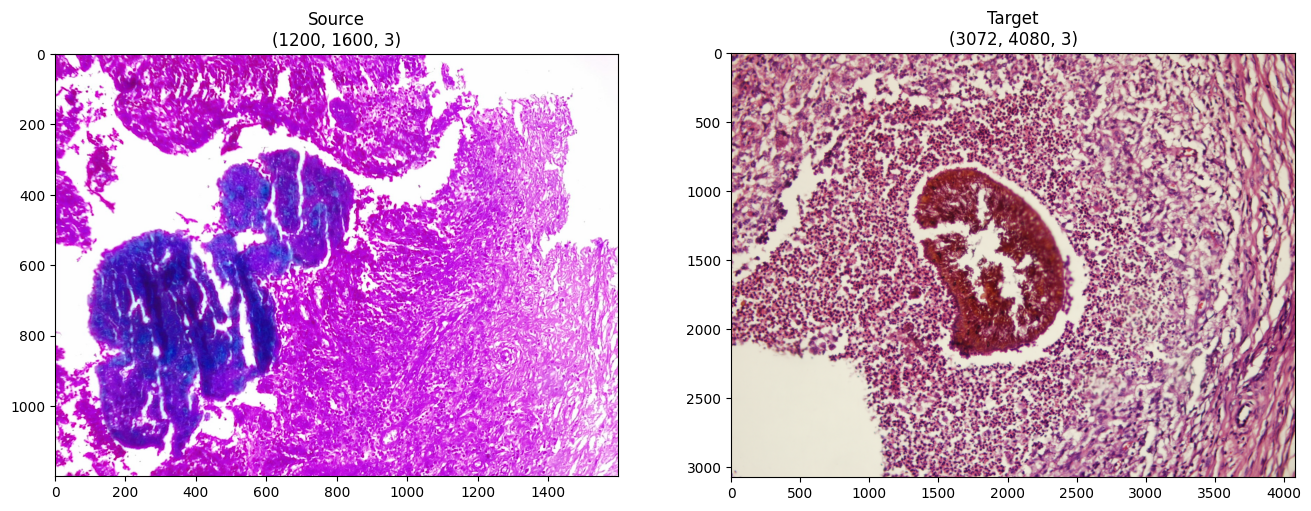

In [ ]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title(f"Source\n{source.shape}")
plt.imshow(source)
plt.subplot(122)
plt.title(f'Target\n{target.shape}')
plt.imshow(target)

Text(0.5, 1.0, 'Reinhard')

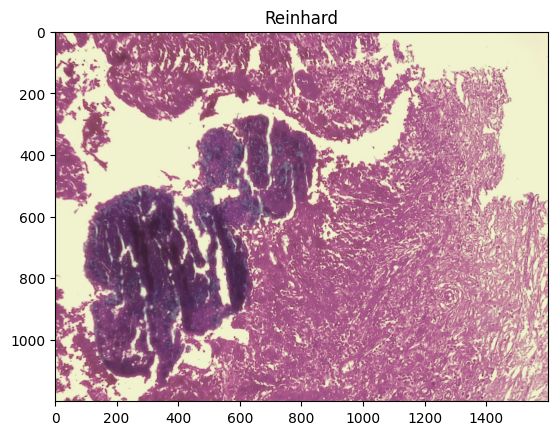

In [ ]:
# run reinhard normalization
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(target))
reinhard_normalized = normalizer.transform(np.array(source))
plt.imshow(reinhard_normalized)
plt.title('Reinhard')

Text(0.5, 1.0, 'Vahadane')

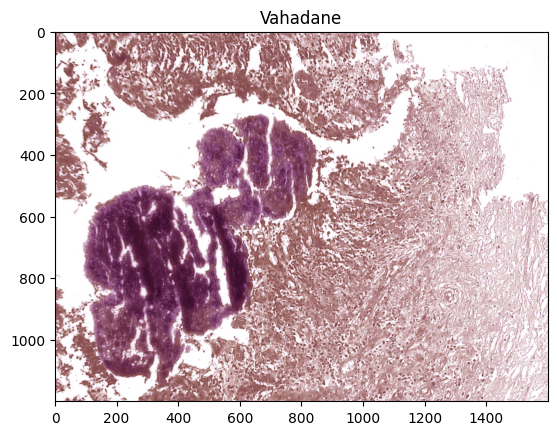

In [ ]:
# run vahadane normalization
np.bool = np.bool_
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(np.array(target))
vahadane_normalized = normalizer.transform(np.array(source))
plt.imshow(vahadane_normalized)
plt.title('Vahadane')

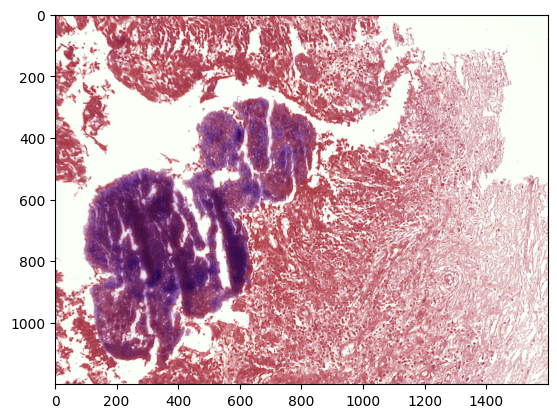

In [ ]:
# run Macenko normalization
import torch
from torchvision import transforms
import torchstain
import cv2

to_transform = source
target2 = target

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
torch_normalizer.fit(T(target2))

t_to_transform = T(to_transform)
norme, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)

import matplotlib.pyplot as plt
plt.imshow(norme)


In [ ]:
#Convert a PyTorch Tensor into a NumPy Array
ccc1 = norme.numpy()


In [ ]:

normalized_imgs = {'Source': source, 'Target': target,
                   'Reinhard': reinhard_normalized, 'Vahadane': vahadane_normalized, 'macenko':ccc1}

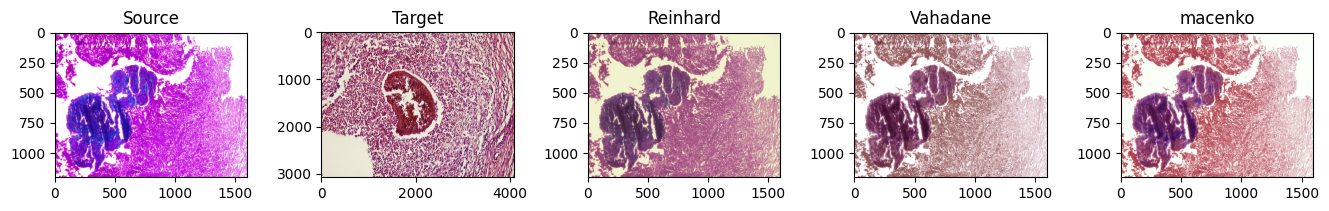

In [ ]:
plt.figure(figsize=(16,16))
for i, (method, img) in enumerate(normalized_imgs.items()):
    plt.subplot(1, 6, i+1)
    plt.title(method)
    plt.imshow(img)
plt.tight_layout()


In [ ]:
#Calculate metrics and display results
#Structural Similarity Index (SSIM)
#Peak Signal-to-Noise Ratio (PSNR)
#The SSIM Source and PSNR Source are used to evaluate the similarity between the normalized
#image and the source image. The SSIM Source is used to measure the preservation of the source image texture information
methods = []
ssim_results = []
psnr_results = []
for i, (method, img) in enumerate(normalized_imgs.items()):
    if i > 1:
        methods.append(method)
        ssim_results.append(ssim(source, img, data_range=img.max() - img.min(), channel_axis=2))
        psnr_results.append(psnr(source, img, data_range=img.max() - img.min()))

In [ ]:
evaluation_table = pd.DataFrame(list(zip(methods, ssim_results, psnr_results)),
                                columns=['Methods', 'SSIM source', 'PSNR source'])
#evaluation_table.style.hide_index().apply(highlight([1,3]), axis=1)

In [ ]:
evaluation_table.style.hide_index()

<ipython-input-15-02b48ef9ba49>:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  evaluation_table.style.hide_index()


Methods,SSIM source,PSNR source
Reinhard,0.868381,13.104665
Vahadane,0.782268,13.180122
macenko,0.812106,13.883441
